# 3D MNIST
This is meant as an exercise in 3D CNNs

In [4]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path
import h5py

In [9]:
# -- Preparatory code --
# Model configuration
batch_size = 100
no_epochs = 30
learning_rate = 0.001
no_classes = 10
validation_split = 0.2
verbosity = 1

In [6]:
path_to_fulldata = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/messing around/3D_MNIST/full_dataset_vectors.h5")

In [2]:
# Convert 1D vector into 3D values, provided by the 3D MNIST authors at
# https://www.kaggle.com/daavoo/3d-mnist
def array_to_color(array, cmap="Oranges"):
  s_m = plt.cm.ScalarMappable(cmap=cmap)
  return s_m.to_rgba(array)[:,:-1]

# Reshape data into format that can be handled by Conv3D layers.
# Courtesy of Sam Berglin; Zheming Lian; Jiahui Jang - University of Wisconsin-Madison
# Report - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/Report.pdf
# Code - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/network_final_version.ipynb
def rgb_data_transform(data):
  data_t = []
  for i in range(data.shape[0]):
    data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
  return np.asarray(data_t, dtype=np.float32)

In [8]:
# -- Process code --
# Load the HDF5 data file
with h5py.File(path_to_fulldata, "r") as hf:

    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]

    # Determine sample shape
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

    # Convert target vectors to categorical targets
    targets_train = tf.keras.utils.to_categorical(targets_train).astype(np.int64) # formerly: np.integer
    targets_test = tf.keras.utils.to_categorical(targets_test).astype(np.int64) # formerly: np.integer

In [15]:
# Create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

In [16]:
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 14, 14, 14, 32)    2624      
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 7, 7, 7, 32)       0         
 g3D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 7, 32)       0         
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 5, 5, 64)       55360     
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 2, 2, 2, 64)       0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 2, 64)      

In [17]:
# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.legacy.Adam(lr=learning_rate),
              metrics=['accuracy'])

# Fit data to model
history = model.fit(X_train, targets_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

Epoch 1/30


/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification/brain_mets_env/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


80/80 [==============================] - 18s 217ms/step - loss: 2.6453 - accuracy: 0.1028 - val_loss: 2.3011 - val_accuracy: 0.1050
Epoch 2/30
80/80 [==============================] - 17s 210ms/step - loss: 2.3012 - accuracy: 0.1109 - val_loss: 2.2999 - val_accuracy: 0.1050
Epoch 3/30
80/80 [==============================] - 17s 208ms/step - loss: 2.2904 - accuracy: 0.1211 - val_loss: 2.2654 - val_accuracy: 0.2100
Epoch 4/30
80/80 [==============================] - 17s 212ms/step - loss: 2.2201 - accuracy: 0.1822 - val_loss: 2.1565 - val_accuracy: 0.2950
Epoch 5/30
80/80 [==============================] - 17s 212ms/step - loss: 2.1330 - accuracy: 0.2342 - val_loss: 2.0250 - val_accuracy: 0.3215
Epoch 6/30
80/80 [==============================] - 17s 213ms/step - loss: 2.0703 - accuracy: 0.2535 - val_loss: 1.9261 - val_accuracy: 0.3605
Epoch 7/30
80/80 [==============================] - 17s 211ms/step - loss: 2.0026 - accuracy: 0.2810 - val_loss: 1.8912 - val_accuracy: 0.3945
Epoch 8/30

Test loss: 1.2059119939804077 / Test accuracy: 0.5914999842643738


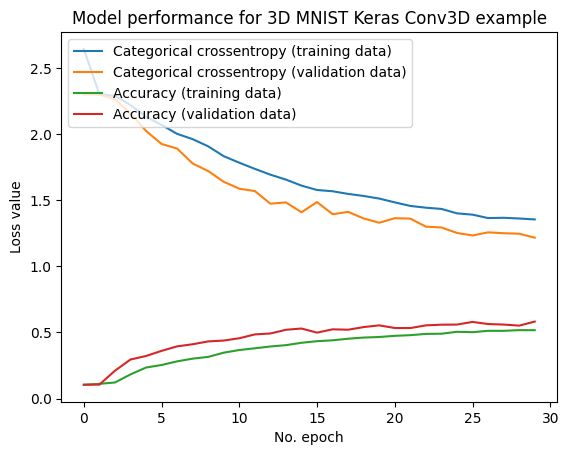

In [18]:
# Generate generalization metrics
score = model.evaluate(X_test, targets_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()